In [1]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.signal.windows import triang
from scipy.ndimage import generate_binary_structure
import pyart
import cv2
from iris import iristools
from iris import utils


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Demonstrate the IRIS SHEAR calculation with Python and reading actual IRIS SHEAR products.

## Calculate shear product with Python

First, read a radar data file.

In [2]:
fn = "201708121600_VAN.PPI1_G.raw"
radar = pyart.io.read_sigmet(fn)
curdate = tt = datetime.strptime(radar.time['units'], 'seconds since %Y-%m-%dT%H:%M:%SZ')
elev = radar.get_elevation(0).mean()
azim = radar.azimuth["data"]


range_filter_len = 3  # Bins, which equals 1500 m in this data
az_filter_len = 3  # Bins, i.e. 3 degrees

Make a copy of the Doppler velocity data and declutter as specified in *IRIS Product and Display manual*

In [3]:
data = radar.fields['velocity']['data'][0:radar.sweep_end_ray_index['data'][0] + 1, :]
data.set_fill_value(0)
data1 = data.copy()
data1 = utils.iris_declutter(data1, range_filter_len, az_filter_len)
data1

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, 26.639999389648438, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=float32)

Calculate radial shear

In [4]:
dr = iristools.diff_radial(data1.data.astype(np.float64),
                      data1.mask.astype(np.int), range_filter_len)
dr = np.ma.array(dr, mask=(dr == 0))

# Convolve with the triangle filter
nr = np.ones(dr.shape)
nr[dr.mask] = 0
tri = np.expand_dims(triang(range_filter_len), axis=0)
kern1 = tri / np.sum(tri)
Wr = convolve2d(nr, kern1, mode="same")
dr = convolve2d(dr, kern1, mode="same")
dr[Wr <= 1 / 2] = 0
dr[Wr > 1 / 2] /= Wr[Wr > 1 / 2]
dr = np.ma.array(dr, mask=data1.mask)

Calculate azimuthal shear

In [5]:
da = iristools.diff_azimuthal(data1.data.astype(np.float64),
                         data1.mask.astype(np.int), az_filter_len)
da = np.ma.array(da, mask=(da == 0))
# Correct for apparent shear caused by mean wind
# Read VVP data
vvp_fn_pattern = "%Y%m%d%H%M_VAN.VVP_40.txt"
altitude = "lowest"
u0, v0 = utils.read_vvp("./", vvp_fn_pattern, curdate, altitude=altitude)
# Calculate correction
u_corr = u0 * np.cos(np.radians(azim)) * np.sin(np.radians(elev))
v_corr = v0 * np.sin(np.radians(azim)) * np.sin(np.radians(elev))
da += np.tile(u_corr[:, np.newaxis], (1, da.shape[1]))
da -= np.tile(v_corr[:, np.newaxis], (1, da.shape[1]))

na = np.ones(da.shape)
na[da.mask] = 0
kern2 = np.array([[1/4, 1/2, 1/4]]).T
Wa = convolve2d(na, kern2, mode="same")
da = convolve2d(da, kern2, mode="same")
da[Wa <= 1/2] = 0
da[Wa > 1/2] /= Wa[Wa > 1/2]
da = np.ma.array(da, mask=data1.mask)

Reproject onto cartesian grid

In [6]:
x = y = np.linspace(-123900, 123900, 1300)
da.set_fill_value(0)
dr.set_fill_value(0)
# Note that when using 500 in reprojection, the resulting coordinates are actually along the beam path, not on ground.
da_proj = utils.polar_to_cart(da.filled(), 1.0, 500, x, y, order=0)
dr_proj = utils.polar_to_cart(dr.filled(), 1.0, 500, x, y, order=0)

# Original velocity data
data_proj = utils.polar_to_cart(data.filled(), 1.0, 500, x, y, order=0)

Plot the fields

In [7]:
# range and azimuth values for plotting
az = np.pad(radar.get_azimuth(0), (0, 1), 'constant', constant_values=361)
rr_los = np.pad(
    radar.range['data'], (0, 1), 'constant',
    constant_values=(radar.range['data'][-1] +
                     radar.range['meters_between_gates'][0]))
rr_ground = utils.bin_distance(rr_los, elev, radar.altitude["data"][0], 6371e3)

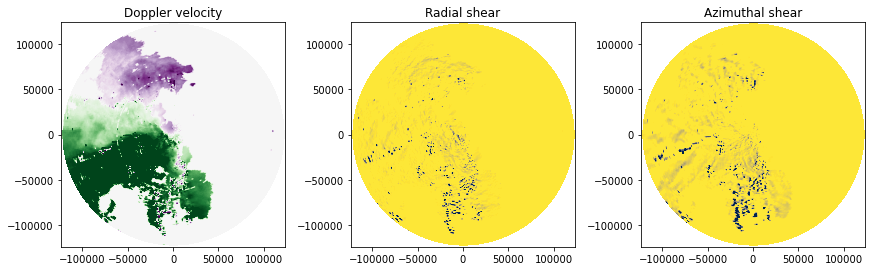

In [8]:
nrows = 1
ncols = 3
fig, axs = plt.subplots(figsize=(4 * ncols, 4 * nrows),
                        nrows=nrows, ncols=ncols,
                        constrained_layout=True)
plot_params_shear = {
    "cmap": "cividis_r",
    "vmin": 0,
    "vmax": 7,
    "rasterized": True,
    "alpha": 1,
    "zorder": 3000,
}
plot_params_Doppler = {
    "cmap": "PRGn_r",
    "vmin": -20,
    "vmax": 20,
    "rasterized": True,
    "alpha": 1,
    "zorder": 3000,
}

axs[0].imshow(data_proj, origin="lower",
              extent=(np.min(x), np.max(x), np.min(y), np.max(y)),
              **plot_params_Doppler)
axs[1].imshow(dr_proj, origin="lower",
              extent=(np.min(x), np.max(x), np.min(y), np.max(y)),
              **plot_params_shear)
axs[2].imshow(da_proj, origin="lower",
              extent=(np.min(x), np.max(x), np.min(y), np.max(y)),
              **plot_params_shear)
axs[0].set_title("Doppler velocity")
axs[1].set_title("Radial shear")
axs[2].set_title("Azimuthal shear")

fig.savefig('201708121600_shear.png', dpi=300)

Calculate thresholds for the image

Text(0.5, 1.0, 'Azimuthal shear, thr: 9, # of areas: 385')

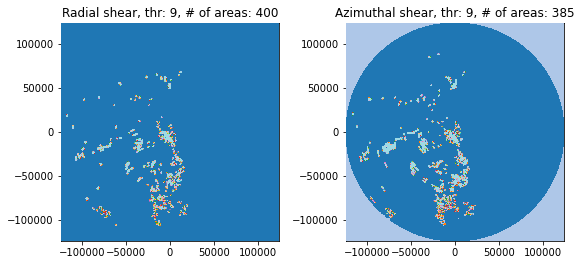

In [9]:
# Select a threshold; note the unit is m/s / 1500m or m/s / 3degrees
thr = 9 

# We want to consider areas connected also on the diagonal, so we provide the structure element
element = generate_binary_structure(2, 2)
n_areas_dr, areas_dr = utils.threshold_field(dr_proj, thr, structure_element=element)
n_areas_da, areas_da = utils.threshold_field(da_proj, thr, structure_element=element)

# Plot the resulting image
nrows = 1
ncols = 2
fig, axs = plt.subplots(figsize=(4 * ncols, 4 * nrows),
                        nrows=nrows, ncols=ncols,
                        constrained_layout=True)
plot_params = {
    "cmap": "tab20",
    "vmin": 0,
    "vmax": 20,
    "rasterized": True,
    "alpha": 1,
    "zorder": 3000,
}

axs[0].imshow(areas_dr, origin="lower", **plot_params, extent=(np.min(x), np.max(x), np.min(y), np.max(y)))
axs[1].imshow(areas_da, origin="lower", **plot_params, extent=(np.min(x), np.max(x), np.min(y), np.max(y)))

axs[0].set_title(f"Radial shear, thr: {thr}, # of areas: {n_areas_dr}")
axs[1].set_title(f"Azimuthal shear, thr: {thr}, # of areas: {n_areas_da}")


Text(0.5, 1.0, 'Dilated radial shear, thr: 9, # of areas: 247')

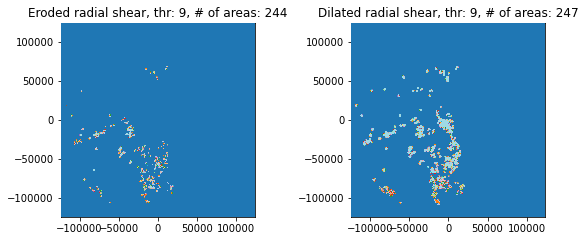

In [10]:
# If we want to, we can apply erosion to remove individual points and/or dilation to connect more areas
# for this, opencv/cv2 is the easiest option, see https://pypi.org/project/opencv-python/
thr = 9

kernel = np.ones((3,3), np.uint8)

tmp = dr_proj.copy()
mask = np.isfinite(tmp) & (np.abs(tmp) >= thr)
tmp[~mask] = 0
tmp[mask] = 1
B = tmp.astype(np.uint8)

dr_eroded = cv2.erode(B, kernel, iterations=1) # erosion
dr_dilated = cv2.dilate(B, kernel, iterations=1) # dilation

# We want to consider areas connected also on the diagonal, so we provide the structure element
# Note that compared to previous, the threshold has to be changed since cv2.erode/dilate returns a binary image
# and the threshold is applied in the previous part
element = generate_binary_structure(2, 2)
n_areas_erode, areas_erode = utils.threshold_field(dr_eroded, 1, structure_element=element)
n_areas_dilate, areas_dilate = utils.threshold_field(dr_dilated, 1, structure_element=element)

# Plot the resulting image
nrows = 1
ncols = 2
fig, axs = plt.subplots(figsize=(4 * ncols, 4 * nrows),
                        nrows=nrows, ncols=ncols,
                        constrained_layout=True)
plot_params = {
    "cmap": "tab20",
    "vmin": 0,
    "vmax": 20,
    "rasterized": True,
    "alpha": 1,
    "zorder": 3000,
}

axs[0].imshow(areas_erode, origin="lower", **plot_params, extent=(np.min(x), np.max(x), np.min(y), np.max(y)))
axs[1].imshow(areas_dilate, origin="lower", **plot_params, extent=(np.min(x), np.max(x), np.min(y), np.max(y)))

axs[0].set_title(f"Eroded radial shear, thr: {thr}, # of areas: {n_areas_erode}")
axs[1].set_title(f"Dilated radial shear, thr: {thr}, # of areas: {n_areas_dilate}")

Text(0.5, 1.0, 'Area-based filtered radial shear, area thr: 2 km^2, \n# of areas: 123')

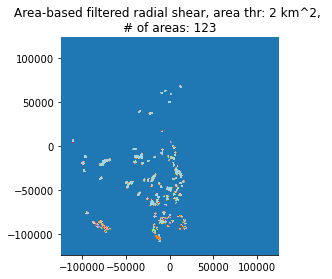

In [11]:
# Filter selected areas based on size

# First check size of our grid
x_res = np.diff(x)[0]  # 190m
y_res = np.diff(y)[0]  # 190m

a_pixel = x_res * y_res * 1e-6  # in km^2

# Threshold for area, in km^2
min_size = 2
# Threshold for number of pixels
min_pixels = np.rint(min_size / a_pixel)

# We will filter the dilated image, so image is stored in areas_dilate, and number of areas in n_areas_dilate

# Areas of each label
label_sizes = [(areas_dilate == label).sum() for label in range(1, n_areas_dilate + 1)]

image = areas_dilate.copy()
# Now remove the labels with too small area
for label, size in enumerate(label_sizes):
    if size < min_pixels:
        image[areas_dilate == label] = 0
        

# Plot the resulting image
nrows = 1
ncols = 1
fig, axs = plt.subplots(figsize=(4 * ncols, 4 * nrows),
                        nrows=nrows, ncols=ncols)#,
#                         constrained_layout=True)
plot_params = {
    "cmap": "tab20",
    "vmin": 0,
    "vmax": 20,
    "rasterized": True,
    "alpha": 1,
    "zorder": 3000,
}

axs.imshow(image, origin="lower", **plot_params, extent=(np.min(x), np.max(x), np.min(y), np.max(y)))
axs.set_title(f"Area-based filtered radial shear, area thr: {min_size} km^2, \n# of areas: {np.unique(image).size - 1}")